MC Basic

Optimal value function:
[[1.4 1.8 2.2 2.7 3.3]
 [1.1 1.4 2.7 3.3 3.8]
 [0.8 0.5 7.9 3.8 4.5]
 [0.5 7.9 7.9 7.9 5.2]
 [0.2 6.9 7.9 6.9 6. ]]
Optimal policy:


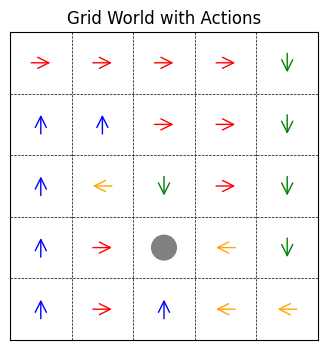

In [151]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy



class Policy:
    """
    Policy class defines an upgradeable policy for a grid world.
    """
    def __init__(self, grid_size):
        # Actions: 0 ↑, 1 →, 2 ↓, 3 ←, 4 stop
        self.policy = {(i, j): random.randint(0, 4) for i in range(grid_size) for j in range(grid_size)}

    def upgrade(self, x, y, action):
        self.policy[x, y] = action


class Reward:
    """
    Reward class defines the reward structure for a grid world.
    """
    def __init__(self, grid_size):
        self.grid_size = grid_size
        self.R = np.zeros((grid_size, grid_size))
        # Terminal states
        self.R[3, 2] = 1
        # Forbidden states
        self.R[1, 1] = self.R[1, 2] = self.R[2, 2] = self.R[3, 1] = self.R[3, 3] = self.R[4, 1] = -10

    def __call__(self, state, action, next_state):
        x, y = state
        x_n, y_n = next_state
        # Boundary conditions and forbidden states
        if x == 0 and action == 0:
            return -1 # 最上面往上走
        elif x == self.grid_size-1 and action == 2:
            return -1 # 最下面往下走
        elif y == 0 and action == 3:
            return  -1 # 最左边往左走
        elif y == self.grid_size-1 and action == 1:
            return  -1 # 最右边往右走
        elif (x == 0 and y == 0 and action == 3) \
                or (x == 0 and y == self.grid_size-1 and action == 1) \
                or (x == self.grid_size-1 and y == 0 and action == 3) \
                or (x == self.grid_size-1 and y == self.grid_size-1 and action == 1):
            return -1
        else:
            return self.R[x_n, y_n]    


def get_next_state(state, action, grid_size):
    """
    Calculate the next state given the current state and action.
    """
    x, y = state
    if action == 0:  # up
        return (max(x - 1, 0), y)
    elif action == 1:  # right
        return (x, min(y + 1, grid_size - 1))
    elif action == 2:  # down
        return (min(x + 1, grid_size - 1), y)
    elif action == 3:  # left
        return (x, max(y - 1, 0))
    elif action == 4:  # stop
        return (x, y)


def poilcy_iteration_MC_basic(grid_size, gamma, length, max_iterations):
    """
    Perform policy iteration to find the optimal policy and value function.
    """
    policy = Policy(grid_size)
    R = Reward(grid_size)
    V = np.zeros((grid_size, grid_size)) 
    Q_pi = np.zeros((grid_size, grid_size, 5)) 
    for _ in range(max_iterations):
        for x in range(grid_size):
            for y in range(grid_size):
                for action in range(5):
                    next_state = get_next_state((x, y), action, grid_size)
                    r = R((x, y), action, next_state)
                    for i in range(length-1):
                        next_state1 = get_next_state(next_state, policy.policy[next_state], grid_size)
                        r += gamma**(i+1)*R(next_state, policy.policy[next_state], next_state1)
                        next_state = copy.copy(next_state1)
                    Q_pi[x,y,action] = r
                policy.upgrade(x, y, np.argmax(Q_pi[x, y, :]))
                V[x, y] = np.max(Q_pi[x, y, :])
    return V, policy

def draw_grid(grid_size, policy):
    """
    绘制网格并根据动作绘制形状。
    
    :param grid_size: 网格的大小
    :param policy: 每个状态的动作策略
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # 绘制网格
    for i in range(grid_size + 1):
        ax.axhline(i, color='k', linestyle='--', linewidth=0.5)
        ax.axvline(i, color='k', linestyle='--', linewidth=0.5)
    
    # 绘制每个网格单元中的动作
    for (x, y), action in policy.policy.items():
        center_x, center_y = y + 0.5, grid_size - x - 0.5  # y + 0.5, grid_size - x - 0.5 确保中心位置正确
        if action == 0:  # ↑
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y - 0.2), (center_x, center_y + 0.2),
                                                 mutation_scale=20, color='blue', arrowstyle='->'))
        elif action == 1:  # →
            ax.add_patch(patches.FancyArrowPatch((center_x - 0.2, center_y), (center_x + 0.2, center_y),
                                                 mutation_scale=20, color='red', arrowstyle='->'))
        elif action == 2:  # ↓
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y + 0.2), (center_x, center_y - 0.2),
                                                 mutation_scale=20, color='green', arrowstyle='->'))
        elif action == 3:  # ←
            ax.add_patch(patches.FancyArrowPatch((center_x + 0.2, center_y), (center_x - 0.2, center_y),
                                                 mutation_scale=20, color='orange', arrowstyle='->'))
        elif action == 4:  # stop
            ax.add_patch(patches.Circle((center_x, center_y), 0.2, color='gray'))

    # 设置轴的属性
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Grid World with Actions')
    
    plt.show()


def main():
    grid_size = 5
    gamma = 0.9
    sample_length = 15
    update_iterations = 20
    
    V, policy = poilcy_iteration_MC_basic(grid_size, gamma, sample_length, update_iterations)
    print("Optimal value function:")
    print(np.round(V, decimals=1))
    print("Optimal policy:")
    draw_grid(grid_size, policy)


if __name__ == "__main__":
    main()

MC Exploring Starts 没写出来

Optimal value function:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Optimal policy:


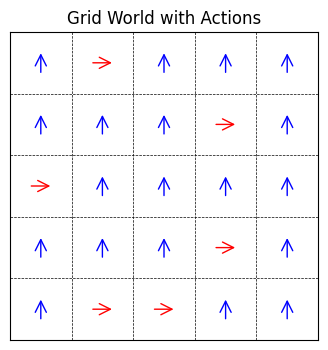

In [159]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy


class Policy:
    """ 
    Policy class defines an upgradeable policy for a grid world.
    """

    def __init__(self, grid_size):
        # Actions: 0 ↑, 1 →, 2 ↓, 3 ←, 4 stop
        self.policy = {(i, j): random.randint(0, 4) for i in range(grid_size) for j in range(grid_size)}

    def upgrade(self, x, y, action):
        self.policy[x, y] = action


class Reward:
    """
    Reward class defines the reward structure for a grid world.
    """

    def __init__(self, grid_size):
        self.grid_size = grid_size
        self.R = np.zeros((grid_size, grid_size))
        # Terminal states
        self.R[3, 2] = 1
        # Forbidden states
        self.R[1, 1] = self.R[1, 2] = self.R[2, 2] = self.R[3, 1] = self.R[3, 3] = self.R[4, 1] = -10

    def __call__(self, state, action, next_state):
        x, y = state
        x_n, y_n = next_state
        # Boundary conditions and forbidden states
        if x == 0 and action == 0:
            return -1  # 最上面往上走
        elif x == self.grid_size - 1 and action == 2:
            return -1  # 最下面往下走
        elif y == 0 and action == 3:
            return -1  # 最左边往左走
        elif y == self.grid_size - 1 and action == 1:
            return -1  # 最右边往右走
        elif (x == 0 and y == 0 and action == 3) \
                or (x == 0 and y == self.grid_size - 1 and action == 1) \
                or (x == self.grid_size - 1 and y == 0 and action == 3) \
                or (x == self.grid_size - 1 and y == self.grid_size - 1 and action == 1):
            return -1
        else:
            return self.R[x_n, y_n]


def get_next_state(state, action, grid_size):
    """
    Calculate the next state given the current state and action.
    """
    x, y = state
    if action == 0:  # up
        return (max(x - 1, 0), y)
    elif action == 1:  # right
        return (x, min(y + 1, grid_size - 1))
    elif action == 2:  # down
        return (min(x + 1, grid_size - 1), y)
    elif action == 3:  # left
        return (x, max(y - 1, 0))
    elif action == 4:  # stop
        return (x, y)


def poilcy_iteration_MC_Exploring_Starts(grid_size, gamma, length, max_iterations):
    """
    Perform policy iteration to find the optimal policy and value function.
    """
    policy = Policy(grid_size)
    R = Reward(grid_size)
    V = np.zeros((grid_size, grid_size))

    for _ in range(max_iterations):
        # 积累了一条Exp
        Exp = []
        state = (random.choice(range(grid_size)), random.choice(range(grid_size)))
        action = random.choice(range(5))
        Q_pi = np.zeros((grid_size, grid_size, 5))
        Exp_state = []
        for i in range(length):
            next_state = get_next_state(state, action, 5)
            r = (gamma ** (i + 1)) * R(state, action, next_state)
            Exp.append([state, action, r])
            Exp_state.append(state)
            state = copy.copy(next_state)
            action = policy.policy[state]
        Return = 0
        for i in range(length):
            Return += copy.copy(Exp[-(i + 1)][2])
            Exp[-(i + 1)][2] = copy.copy(Return)
        Exist_state = []
        for i in range(length):
            if Exp[i][0] not in Exist_state:
                Exist_state.append(Exp[i][0])
                cx, cy = Exp[i][0]
                Q_pi[cx, cy, Exp[i][1]] = Exp[i][2]

        # Policy improvement
        for state in Exist_state:
            x, y = state
            policy.upgrade(x, y, np.argmax(Q_pi[x, y, :]))
            V[x, y] = np.max(Q_pi[x, y, :])
    return V, policy


def draw_grid(grid_size, policy):
    """
    绘制网格并根据动作绘制形状。

    :param grid_size: 网格的大小
    :param policy: 每个状态的动作策略
    """
    fig, ax = plt.subplots(figsize=(4, 4))

    # 绘制网格
    for i in range(grid_size + 1):
        ax.axhline(i, color='k', linestyle='--', linewidth=0.5)
        ax.axvline(i, color='k', linestyle='--', linewidth=0.5)

    # 绘制每个网格单元中的动作
    for (x, y), action in policy.policy.items():
        center_x, center_y = y + 0.5, grid_size - x - 0.5  # y + 0.5, grid_size - x - 0.5 确保中心位置正确
        if action == 0:  # ↑
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y - 0.2), (center_x, center_y + 0.2),
                                                 mutation_scale=20, color='blue', arrowstyle='->'))
        elif action == 1:  # →
            ax.add_patch(patches.FancyArrowPatch((center_x - 0.2, center_y), (center_x + 0.2, center_y),
                                                 mutation_scale=20, color='red', arrowstyle='->'))
        elif action == 2:  # ↓
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y + 0.2), (center_x, center_y - 0.2),
                                                 mutation_scale=20, color='green', arrowstyle='->'))
        elif action == 3:  # ←
            ax.add_patch(patches.FancyArrowPatch((center_x + 0.2, center_y), (center_x - 0.2, center_y),
                                                 mutation_scale=20, color='orange', arrowstyle='->'))
        elif action == 4:  # stop
            ax.add_patch(patches.Circle((center_x, center_y), 0.2, color='gray'))

    # 设置轴的属性
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Grid World with Actions')

    plt.show()


def main():
    grid_size = 5
    gamma = 0.9
    sample_length = 15
    update_iterations = 20

    V, policy = poilcy_iteration_MC_Exploring_Starts(grid_size, gamma, sample_length, update_iterations)
    print("Optimal value function:")
    print(np.round(V, decimals=1))
    print("Optimal policy:")
    draw_grid(grid_size, policy)


if __name__ == "__main__":
    main()